<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.3.1 
# *Support Vector Machines*

SVMs use linear algebra to find an (n-1)-dimensional boundary that separates classes within an n-dimensional space. In practical terms, this technique provides a conceptually simple way to predict class membership from a set of features. 

The standard (linear) SVM is immediately applicable to linear classification problems. Furthermore, by applying transformations to the feature space it is possible to tackle nonlinear classificaiton problems. These transforms are called *kernels*.

### 1. Load Data

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server: ftp ftp.cs.wisc.edu cd math-prog/cpo-dataset/machine-learn/WDBC/

Also can be found on UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

Attribute Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, train_test_split
import sklearn.metrics as sm
from scipy.stats import pointbiserialr, pearsonr

In [97]:
breast_cancer_csv = 'data/breast-cancer-wisconsin-data.csv'
cancer = pd.read_csv(breast_cancer_csv)
cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


### 2. EDA 

- Explore dataset. Clean data (if required)
- Find features to predict class

In [98]:
# Drop id and vestigial column at end
cancer.drop(['id','Unnamed: 32'], axis=1, inplace=True)

In [99]:
# Check for null values and datatypes
cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [100]:
# Change 'diagnosis' to a binary
cancer.diagnosis = cancer.diagnosis == 'M'

print(cancer.diagnosis.dtypes)

bool


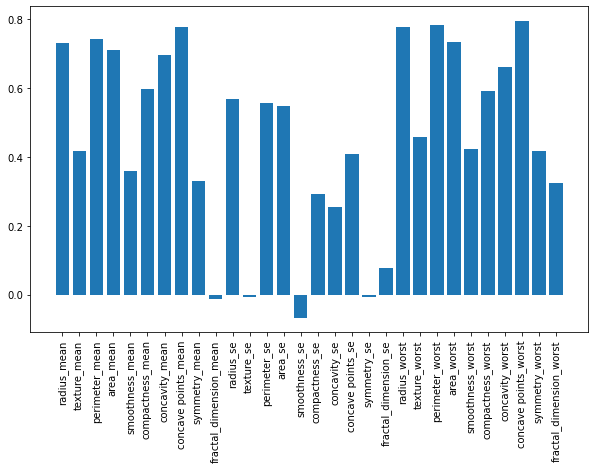

In [101]:
# Plot correlation of each feature with the diagnosis
correlation = []
columnnames = cancer.drop('diagnosis', axis=1).columns
for i in columnnames:
    correl = pointbiserialr(cancer['diagnosis'], cancer[i])
    correlation.append(correl[0])
ax = plt.figure(figsize=(10,6))
ax = plt.bar(columnnames, correlation)
plt.xticks(rotation=90)
plt.show()


In [102]:
# Remove columns with < 0.2 correlation
droppedcolumns = list(columnnames[np.array(correlation) < 0.2])
cancer.drop(droppedcolumns, axis=1, inplace=True)

In [103]:
# Create features and target
X = cancer.drop('diagnosis', axis=1)
y = cancer['diagnosis']

### 3. Logistic Regression Model

#### 3.1 Use Logistic Regression

Use Logistic Regression and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [132]:
# define function to generate desired outputs
def model_eval(model, X, y):
    # Generate train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Fit model and predict
    trained_model = model.fit(X_train, y_train)
    y_predict = trained_model.predict(X_test)
    y_score = trained_model.predict_proba(X_test)[:, 1]

    # Find fpr/tpr
    fpr, tpr, _ = sm.roc_curve(y_test, y_score)

    # Generate metrics
    try:
        best_params = trained_model.best_estimator_
        print('Optimised parameters:', best_params)
    except:
        print("No parameter optimisation performed \n")
    accuracy = sm.accuracy_score(y_test, y_predict)
    confusion = sm.confusion_matrix(y_test, y_predict)
    classification = sm.classification_report(y_test, y_predict)

    print('\nAccuracy Score:', accuracy)
    print('\nConfusion Matrix:\n', confusion)
    print('\nClassification Report:\n', classification)

    # Return fpr and tpr for later use
    return fpr, tpr

In [136]:
# Use for logistic regression
fpr, tpr = model_eval(LogisticRegression(max_iter=2500), X, y)

No parameter optimisation performed 


Accuracy Score: 0.9298245614035088

Confusion Matrix:
 [[64  3]
 [ 5 42]]

Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.96      0.94        67
        True       0.93      0.89      0.91        47

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.93       114
weighted avg       0.93      0.93      0.93       114



### 4. Support Vector Machine

#### 4.1 Use Support Vector Machine

Use Support Vector Machine and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [137]:
# Use function with SVC
fpr, tpr = model_eval(SVC(probability=True), X, y)

No parameter optimisation performed 


Accuracy Score: 0.9210526315789473

Confusion Matrix:
 [[75  2]
 [ 7 30]]

Classification Report:
               precision    recall  f1-score   support

       False       0.91      0.97      0.94        77
        True       0.94      0.81      0.87        37

    accuracy                           0.92       114
   macro avg       0.93      0.89      0.91       114
weighted avg       0.92      0.92      0.92       114



### 5. Naive Bayes
#### 5.1 Use Naive Bayes

Use Naive Bayes and examine accuracy score, confusion matrix, classification report for that model.

- Define Target, Predictors
- Train-Test Split
- Evaluate Model

In [138]:
# Use function with Gaussian NB
fpr_NB, tpr_NB = model_eval(GaussianNB(), X, y)

No parameter optimisation performed 


Accuracy Score: 0.9473684210526315

Confusion Matrix:
 [[71  4]
 [ 2 37]]

Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.95      0.96        75
        True       0.90      0.95      0.92        39

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.94       114
weighted avg       0.95      0.95      0.95       114



### 6 Gridsearch optimal parameters for all three models.

Is there any difference between accuracy score of Logistic Regression and SVM? Use grid serach to find optimal parameter for both these models.

> Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier, alpha for Lasso, etc.

> It is possible and recommended to search the hyper-parameter space for the best cross validation score.

> https://scikit-learn.org/stable/modules/grid_search.html#grid-search

**Note:** It'll take time to execute this. After running the cell, wait for result.

#### 6.1 Find Best Estimator For Logistic Regression 

Find out how these parameters effect model. Find out the best estimator, score.

In [139]:
# Put parameters to change in a dictionary - does not accept changing penalty
lr_params = {'C': [0.1, 1, 5, 10, 50, 100]}
# Create gridsearch object
lr_grid = GridSearchCV(LogisticRegression(max_iter=10000), param_grid=lr_params, cv=4)

# Call function
fpr_LR, tpr_LR = model_eval(lr_grid, X, y)


Optimised parameters: LogisticRegression(C=100, max_iter=10000)

Accuracy Score: 0.9649122807017544

Confusion Matrix:
 [[71  3]
 [ 1 39]]

Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.96      0.97        74
        True       0.93      0.97      0.95        40

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



#### 6.2 Find Best Estimator For SVM

Find out how these parameters effect model. Find out the best estimator, score.

In [143]:
svc_params = {
    'C': [1, 10, 100],
    'gamma': [0.001, 0.0001],
    'kernel': ['linear','rbf']
}

# Create gridsearch object
svc_grid = GridSearchCV(SVC(probability=True), param_grid=svc_params, cv=4)

# Call function
fpr_SVC, tpr_SVC = model_eval(svc_grid, X, y)

Optimised parameters: SVC(C=1, gamma=0.001, kernel='linear', probability=True)

Accuracy Score: 0.956140350877193

Confusion Matrix:
 [[67  0]
 [ 5 42]]

Classification Report:
               precision    recall  f1-score   support

       False       0.93      1.00      0.96        67
        True       1.00      0.89      0.94        47

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



#### 6.3 Plot the ROC curve for the SVM, Logistic Regressions and Naive Bayes on the same plot

Find out which model performs better.

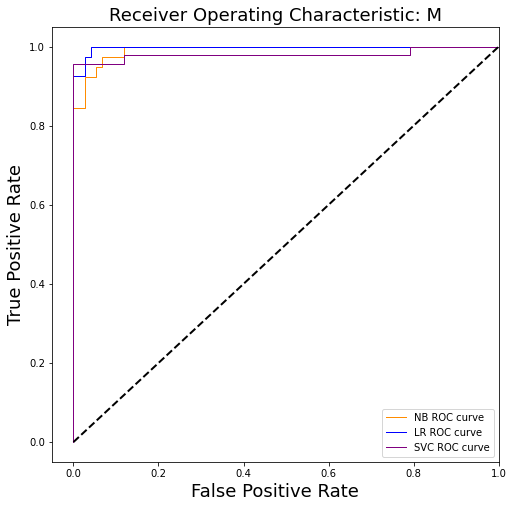

In [144]:
plt.figure(figsize=[8,8])

# Plot ROC curves
plt.plot(fpr_NB, tpr_NB, color='darkorange', lw=1, label='NB ROC curve')
plt.plot(fpr_LR, tpr_LR, color='blue', lw=1, label='LR ROC curve')
plt.plot(fpr_SVC, tpr_SVC, color='purple', lw=1, label='SVC ROC curve')
# Plot midline and fill in chart details
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver Operating Characteristic: M', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### 7. [BONUS] Learning Curve

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error. If both the validation score and the training score converge to a value that is too low with increasing size of the training set, we will not benefit much from more training data.

Plot "learning curves" for the best models of each. This is a great way see how training/testing size affects the scores. Look at the documentation for how to use this function in sklearn.

http://scikit-learn.org/stable/modules/learning_curve.html#learning-curves

In [111]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [145]:
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\jacks\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

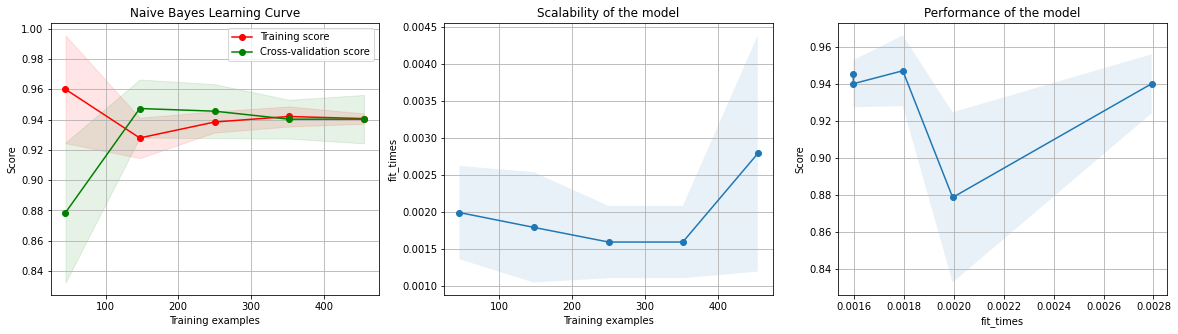

In [146]:
# Plot for all three models
plot_learning_curve(GaussianNB(), 'Naive Bayes Learning Curves', X, y)

The NB model training score and cv score converge on each other as training sample size increases.
<br><br>
Model has flat fit time until the higher end of the chosen train size, where it spikes. Generally very low fit times.
<br><br>
Model performance does not seem to correlate too highly to fit time.

<module 'matplotlib.pyplot' from 'C:\\Users\\jacks\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

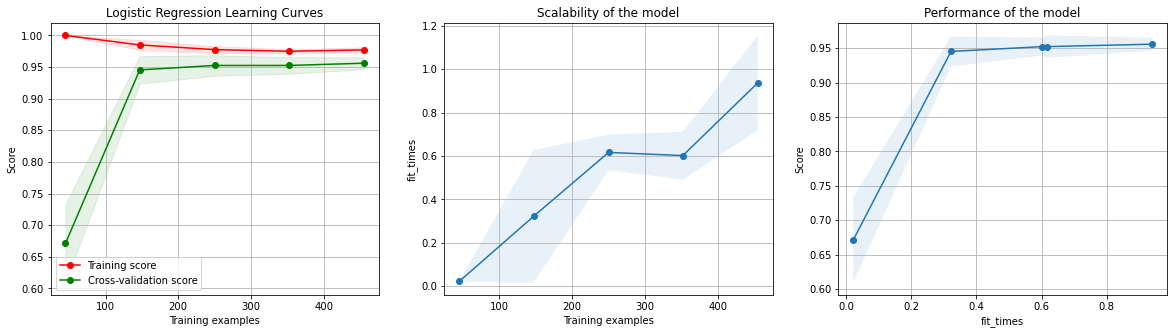

In [147]:
plot_learning_curve(LogisticRegression(C=100, max_iter=10000), 'Logistic Regression Learning Curves', X, y)

The logistic regression model cv score approaches the training score as training sample size increases - training score does not move much, suggesting that logistic regression requires cross-validation more than other models to ensure model accuracy.
<br><br>
Model fit times correlate well with increasing train sample size. Approximately linear, greater fit times than NB by almost two orders of magnitude
<br><br>
Model performance peaks early on into fit times, suggesting that after a certain point, adding more training data does not improve performance enough to justify increased computation load.

<module 'matplotlib.pyplot' from 'C:\\Users\\jacks\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

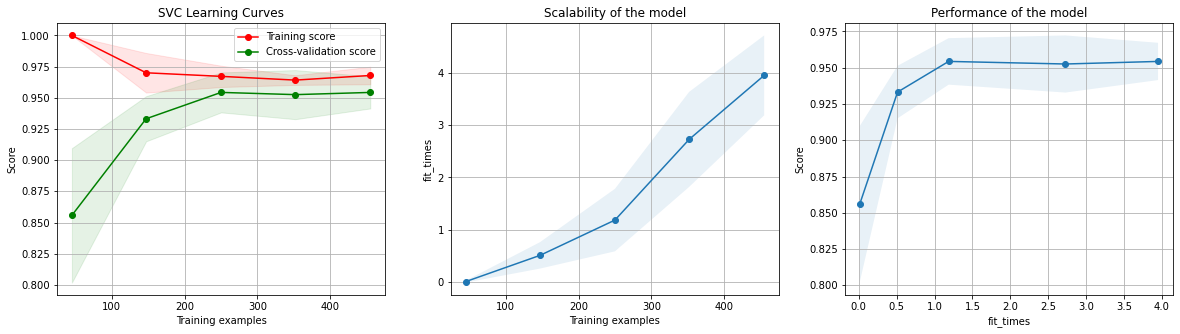

In [149]:
plot_learning_curve(SVC(C=1, gamma=0.001, kernel='linear', probability=True),'SVC Learning Curves', X, y)

The SVC model training score and cv score converge on each other as training sample size increases.
<br><br>
Model has strong positive relationship between fit time and training size, has fit times an order of magnitude greater than logistic regression
<br><br>
Model performance behaves similarly to logistic regression with respect to fit times.

**References**

[Breast Cancer Wisconsin (Diagnostic) Data Set](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data/downloads/breast-cancer-wisconsin-data.zip/2)

[Validation curves: plotting scores to evaluate models](https://scikit-learn.org/stable/modules/learning_curve.html#learning-curves)

[In-Depth: Support Vector Machines](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

[Understanding Support Vector Machine algorithm from examples (along with code)](https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/)

[Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)



---



---



> > > > > > > > > © 2021 Institute of Data


---



---



